<a href="https://colab.research.google.com/github/martinsphl/MAI5035/blob/main/TAREFA_1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MAI5035: Task 1.2 by Paulo Martins, Vitória Barbosa and Isaac Saito

## Problem Definition

The foreign exchange market is a complex, volatile and high-risk system. Independent individuals and companies follow the price of the US dollar to decide on buying/selling of various kinds, such as import contracts, electronics purchases, financial market shares, etc.

**Purpose of the Analysis**

The aim of this analysis is to predict the future price of the dollar, considering a time window of 28 days. In this sense, we will offer categories as a target column that represent the future variation of the dollar.

As this is a classification problem, we will use KNN and Logistic Regression to predict the categories.


## Importing Main Libraries

In [168]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms

# Preprocess data: normalization and ordinal enconder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder

# For Classification Task
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Avoiding warning messages
import warnings
warnings.filterwarnings('ignore')

# Setting a global seed
np.random.seed(7)

## Data Gathering

We created a github public repository to upload the csv dataset and do software versioning. From github public url, we load the data into a pandas dataframe.

**Data Description:**

US Dollar Index dataset ([Available Here](https://www.kaggle.com/datasets/balabaskar/us-dollar-index-data))

1.   Date: Date of observation (time variable in the format Month DD, YYYY)
2.   Price: Dollar index at market close (continuous and positive variable)
3.   Open: Dollar index at market opening (continuous and positive variable)
4.  High: Highest index value observed on the day (continuous, positive variable)
5. Low: Lowest index value observed on the day (continuous, positive variable)
6. Change %: Change in the dollar index compared to the previous day (continuous variable in percent)

In [169]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/US%20Dollar%20Index%20Historical%20Data.csv'

# Creating pandas dataframe from each dataset
df_dollar = pd.read_csv(dataset_url, names=['date', 'last_price', 'first_price', 'biggest_price', 'lowest_price', 'perc_variation'], skiprows=1, delimiter=',')

# Remove '%'symbol from pec_variation column
df_dollar['perc_variation'] = df_dollar['perc_variation'].str[:-1]
df_dollar['perc_variation'] = df_dollar['perc_variation'].astype(float)

# Show some rows
print(df_dollar.head(5).to_markdown())

|    | date         |   last_price |   first_price |   biggest_price |   lowest_price |   perc_variation |
|---:|:-------------|-------------:|--------------:|----------------:|---------------:|-----------------:|
|  0 | Jan 02, 2001 |       108.77 |        109.33 |          109.65 |         108.64 |            -0.72 |
|  1 | Jan 03, 2001 |       110.17 |        108.59 |          110.34 |         108.09 |             1.29 |
|  2 | Jan 04, 2001 |       108.81 |        110.3  |          110.4  |         108.51 |            -1.23 |
|  3 | Jan 05, 2001 |       108.42 |        108.64 |          109.31 |         108.26 |            -0.36 |
|  4 | Jan 08, 2001 |       108.86 |        108.33 |          109.19 |         108.23 |             0.41 |


As you can see, the previous dataset there are few features. So we decided to enrich this one using other dataframe, which was filtered for the main 6 currencies based on Euro price:

**Data Description:**

Daily Exchange Rates per Euro ([Available Here](https://www.kaggle.com/datasets/lsind18/euro-exchange-daily-rates-19992020))

1.   Period: Date of observation (time variable in YYYY-MM-DD format)
2.   US dollar: Value of 1 euro in US dollars (continuous and positive variable)
3.   Japanese Yen: Value of 1 euro in Japanese Yen (continuous and positive variable)
4.   Australian dollar: Value of 1 euro in Australian dollar (continuous and positive variable)
5.   Canadian dollar: Value of 1 euro in Canadian dollars (continuous and positive variable)
6.   Swiss franc : Value of 1 euro in Swiss franc (continuous positive variable)
7.   UK pound sterling: Value of 1 euro in pound sterling (continuous and positive variable)
8. Other columns: Value of 1 euro in other currencies (continuous and positive variable). Other currencies are outside the scope of this analysis as they have little impact on the dollar rate, according to the business.

In [170]:
# Defining the url of each dataset
dataset_url = 'https://raw.githubusercontent.com/martinsphl/MAI5035/refs/heads/main/euro-daily-hist_1999_2022.csv'

# Creating pandas dataframe
columns = ['date','australian_dollar','bulgarian_lev','brazilian_real','canadian_dollar','swiss_franc','chinese_yuan',	'cypriot_pound','czech_koruna','danish_krone','estonian_kroon','uk_pound',	'greek_drachma','hk_dollar','croatian_kuna','hungarian_forint',	'indonesian_rupiah','israeli_shekel','indian_rupee','iceland_krona','japanese_yen','korean_won','lithuanian_litas','latvian_lats','maltese_lira','mexican_peso','malaysian_ringgit','norwegian_krone','new_zealand_dollar','philippine_peso','polish_zloty','romanian_leu','russian_rouble','swedish_krona','singapore_dollar','slovenian_tolar','slovak_koruna','thai_baht','turkish_lira','us_dollar','south_african_rand']
df_euro = pd.read_csv(dataset_url, names=columns, skiprows=1, delimiter=',')

print(df_euro.head(5).to_markdown())

|    | date       |   australian_dollar |   bulgarian_lev |   brazilian_real |   canadian_dollar |   swiss_franc |   chinese_yuan |   cypriot_pound |   czech_koruna |   danish_krone |   estonian_kroon |   uk_pound |   greek_drachma |   hk_dollar |   croatian_kuna |   hungarian_forint |   indonesian_rupiah |   israeli_shekel |   indian_rupee |   iceland_krona |   japanese_yen |   korean_won |   lithuanian_litas |   latvian_lats |   maltese_lira |   mexican_peso |   malaysian_ringgit |   norwegian_krone |   new_zealand_dollar |   philippine_peso |   polish_zloty |   romanian_leu |   russian_rouble |   swedish_krona |   singapore_dollar |   slovenian_tolar |   slovak_koruna |   thai_baht |   turkish_lira |   us_dollar |   south_african_rand |
|---:|:-----------|--------------------:|----------------:|-----------------:|------------------:|--------------:|---------------:|----------------:|---------------:|---------------:|-----------------:|-----------:|----------------:|------------:|---

In [171]:
# Merge both dataframe
df_euro['date'] = pd.to_datetime(df_euro['date']).dt.strftime('%Y-%m-%d')
df_dollar['date'] = pd.to_datetime(df_dollar['date']).dt.strftime('%Y-%m-%d')
df_enriched = pd.merge(df_dollar, df_euro, on=['date'], how='inner')
df_euro = None
df_dollar = None

# Be sure there are only numeric values into the columns
columns = df_enriched.columns.to_list()
columns.remove('date')
list_date = df_enriched['date']
df_enriched = df_enriched.loc[:, columns].apply(pd.to_numeric, errors='coerce')
df_enriched['date'] = list_date

## Data Exploration
On this stage, we will get knowlodge on data. So, we'll check the type of columns and how many null values there are; since this point, all next exploratory analysis will be under numerics columns: check descriptive statistics, density distribution and outliers occurrences by IQR.

**Feature Selection**

At this point, we'll check the set of uncorrelated features and filter the clean data set only for these features.

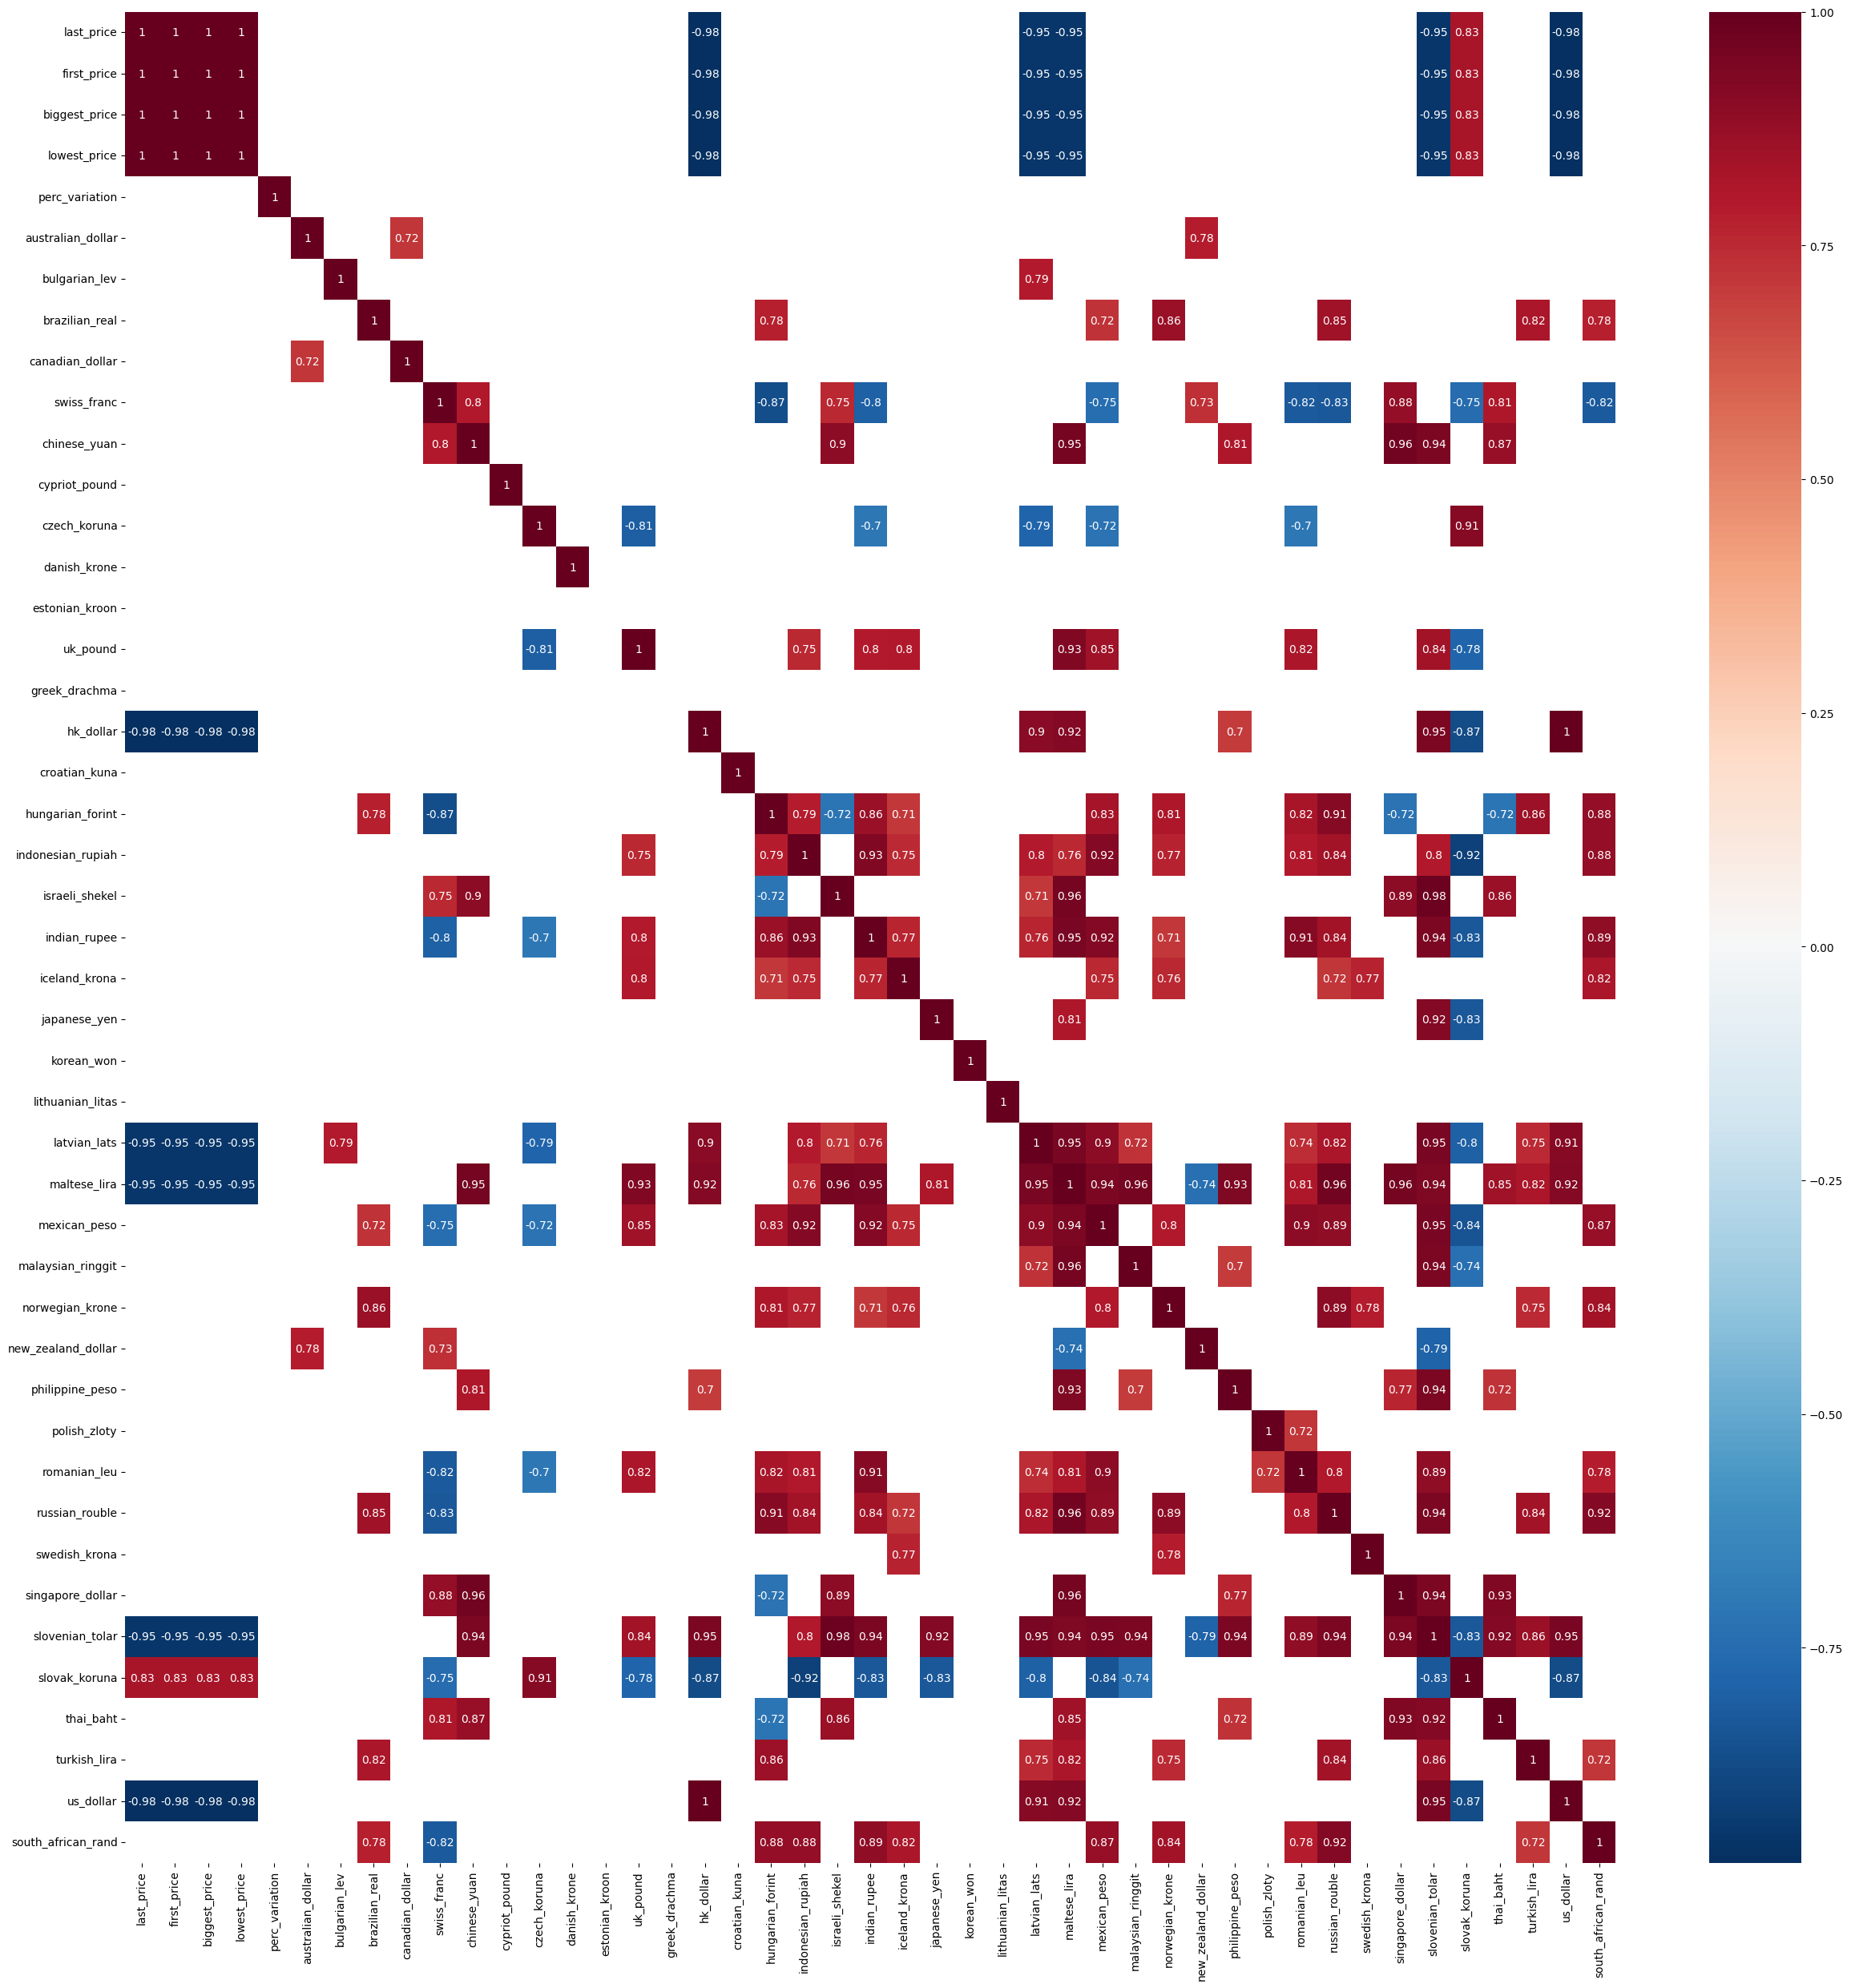

In [172]:
# Correlation matrix for strongly correlated positive or negative values
plt.figure(figsize=(30, 30))
correlation_matrix = df_enriched.iloc[:, :-1].corr()
mask = (correlation_matrix > 0.70) | (correlation_matrix < -0.70)
sns.heatmap(correlation_matrix[mask], annot=True, cmap='RdBu_r')
plt.show()

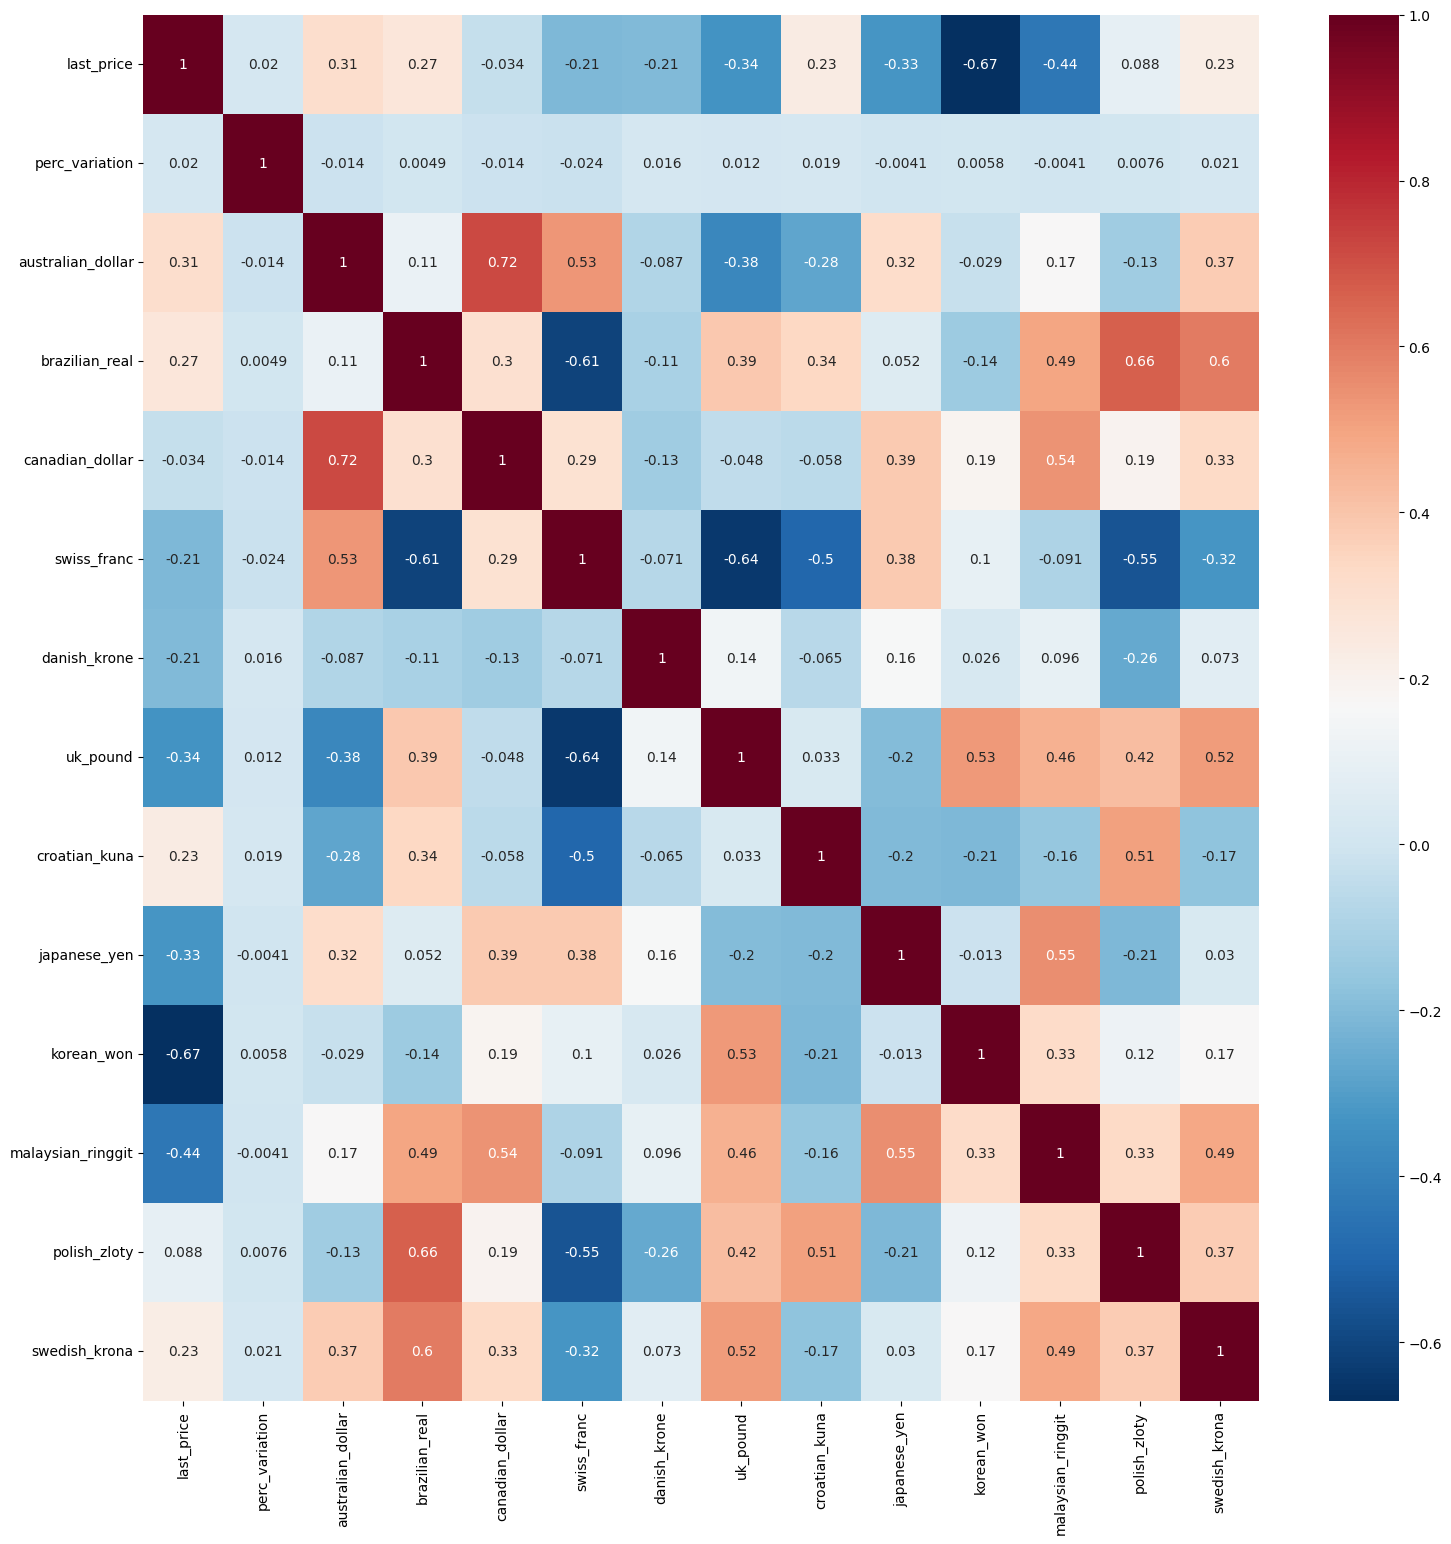

In [173]:
# List all correlacted features
lst_features = df_enriched.columns.to_list()
lst_correlated_features = ['first_price', 'biggest_price', 'lowest_price', 'slovenian_tolar', 'slovak_koruna', 'us_dollar', 'turkish_lira', 'south_african_rand', 'singapore_dollar', 'thai_baht', 'hungarian_forint']
lst_correlated_features += ['latvian_lats', 'mexican_peso', 'norwegian_krone', 'new_zealand_dollar', 'russian_rouble', 'hk_dollar', 'maltese_lira', 'czech_koruna', 'indonesian_rupiah', 'indian_rupee', 'iceland_krona', 'estonian_kroon', 'greek_drachma']
lst_correlated_features += ['chinese_yuan', 'romanian_leu', 'cypriot_pound', 'lithuanian_litas', 'bulgarian_lev', 'philippine_peso', 'israeli_shekel']

# Removing correlated features
for col in lst_correlated_features:
  lst_features.remove(col)

# Show the correlation between the features sample
df_cleaned = df_enriched.loc[:, lst_features]
plt.figure(figsize=(18, 18))
sns.heatmap(df_cleaned.iloc[:, :-1].corr(), annot=True, cmap='RdBu_r')
plt.show()

Although the Canadian and Austrailia dollar have a correlation of just over 70%, we know from business knowledge that these currencies are important for the price of the US dollar, so we decided to keep them.

Total of rows 5569


<Axes: >

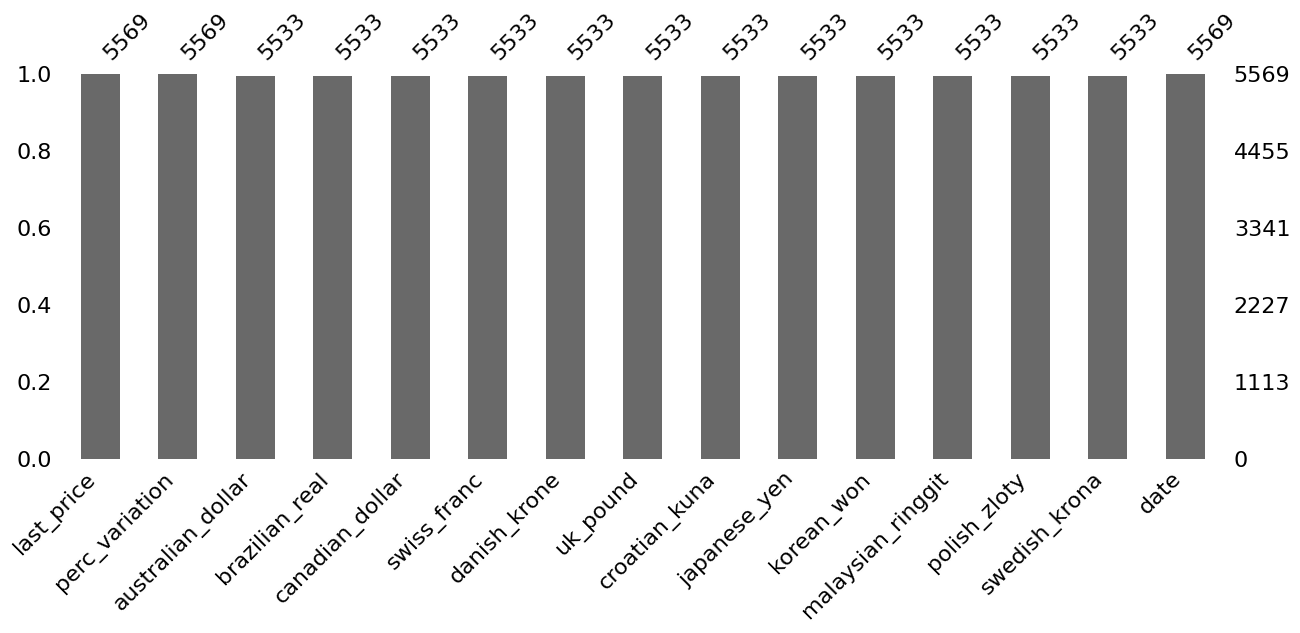

In [174]:
# Check how many Missing Values there are
print(f"Total of rows {df_cleaned.shape[0]}")
ms.bar(df_cleaned, figsize=(15,5))

In [175]:
# Checking the Descriptive Statistics of numerics columns
print(df_cleaned.describe())

        last_price  perc_variation  australian_dollar  brazilian_real  \
count  5569.000000     5569.000000        5533.000000     5533.000000   
mean     90.478107        0.001219           1.572534        3.463612   
std      10.708799        0.485459           0.155623        1.172879   
min      71.330000       -3.020000           1.163900        1.799400   
25%      81.430000       -0.280000           1.465700        2.595800   
50%      89.940000        0.000000           1.594300        3.167900   
75%      96.930000        0.270000           1.673100        3.961500   
max     120.900000        2.560000           2.073500        6.955300   

       canadian_dollar  swiss_franc  danish_krone     uk_pound  croatian_kuna  \
count      5533.000000  5533.000000   5533.000000  5533.000000    5533.000000   
mean          1.465625     1.314896      7.448481     0.787610       7.458325   
std           0.095128     0.209298      0.011386     0.093446       0.124425   
min           1.21

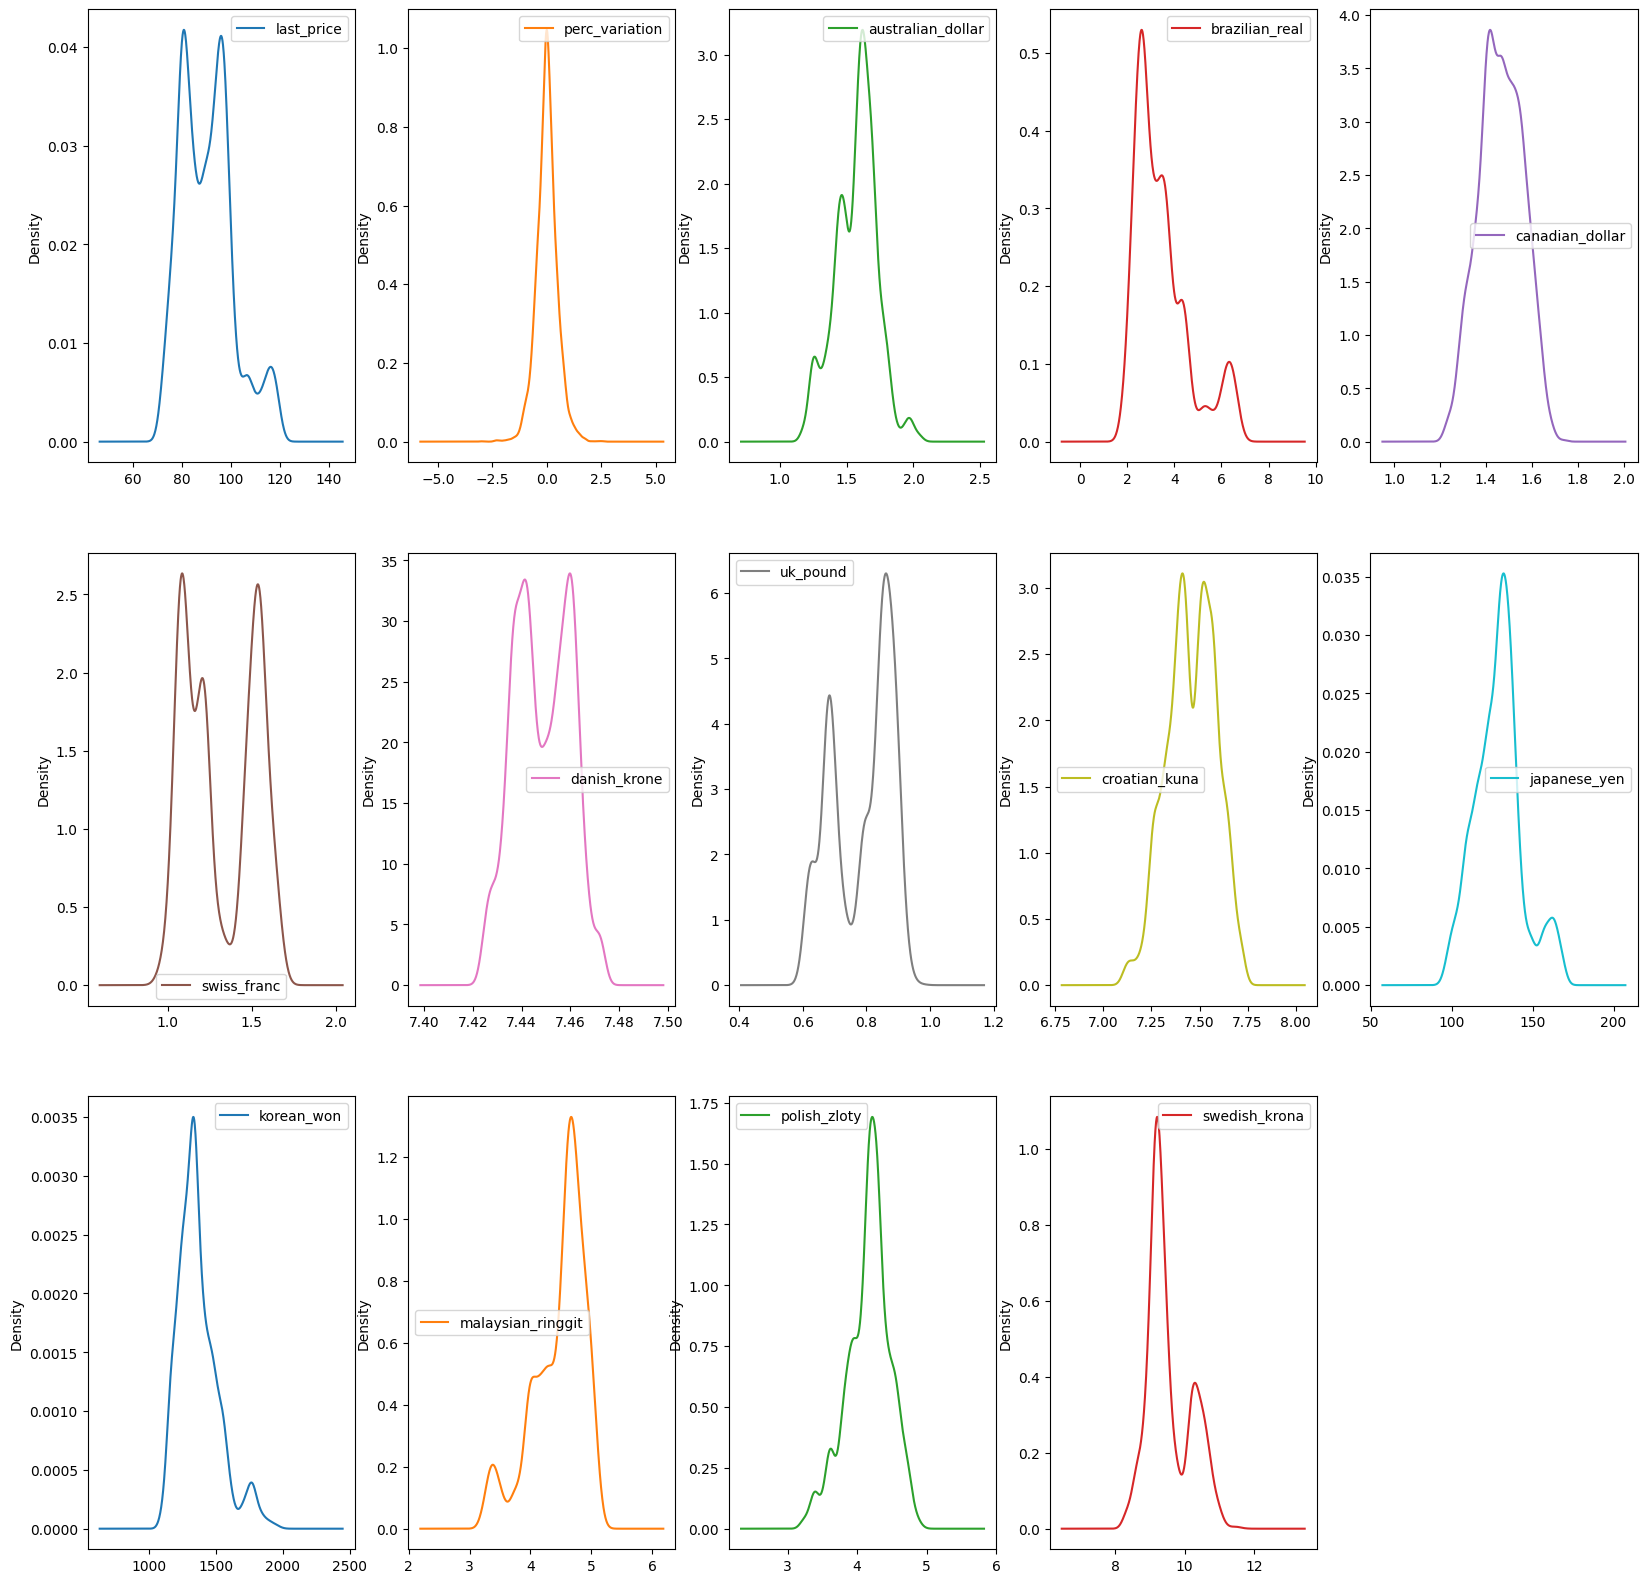

In [185]:
# Now let's check the density distribution of numeric columns
df_cleaned.plot(kind = 'density', subplots = True, layout = (3,5), sharex = False, figsize = (20,20))
plt.show()


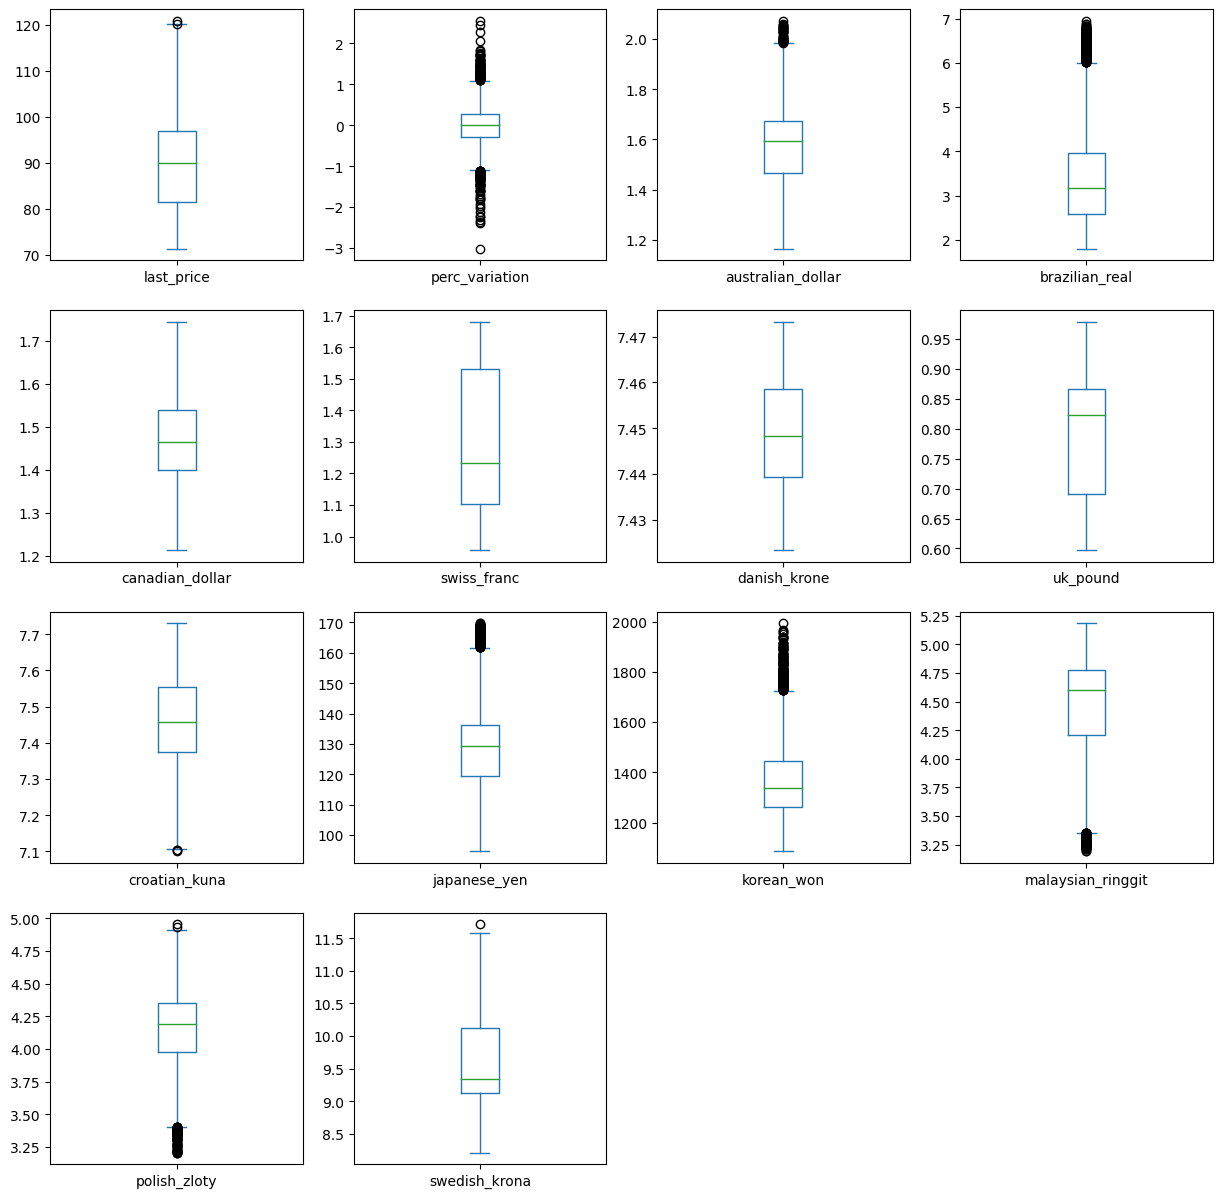

In [177]:
# Finally verifying if there is any outlier values based on IQR technique
df_cleaned.plot(kind = 'box', subplots = True, layout = (3,5), sharex = False, sharey = False, figsize = (20,20))
plt.show()

## Data Cleansing up

This chapter is to preprocess the data before applying any machine learning algorithm. Therefore, we will detect outlier and null values to replace those for estimated value.

### Replace Outlier Values

### Replace Missing Values

### Double-checking on cleaned dataframe

## Feature Engineering



In [178]:
# Ordering the data
df_enriched.sort_values(by=['date'], ascending=True)

# Create 3 new features
df_enriched['date'] = pd.to_datetime(df_enriched['date'])
df_enriched['day'] = df_enriched['date'].dt.day
df_enriched['month'] = df_enriched['date'].dt.month
df_enriched['year'] = df_enriched['date'].dt.year

df_enriched.drop(columns=['date'], axis=1, inplace=True)

# Future Dollar Price in 28 days

# Moving-average of last 28 days

We know that the currency market is volatile and perhaps the discrepant values identified in the perc_variation column are a reflection of the market. Just for verification purposes, we will recalculate all the values in this column according to the official documentation

In [179]:
df_enriched['calculated_perc_variation'] = 100 * ((df_enriched['last_price'] / df_enriched['last_price'].shift()) - 1)
df_enriched.loc[0, 'calculated_perc_variation'] = df_enriched.loc[0, 'perc_variation']
print(df_enriched[['perc_variation', 'calculated_perc_variation']].describe())

       perc_variation  calculated_perc_variation
count     5569.000000                5569.000000
mean         0.001219                   0.001271
std          0.485459                   0.485685
min         -3.020000                  -3.018085
25%         -0.280000                  -0.275716
50%          0.000000                   0.000000
75%          0.270000                   0.273335
max          2.560000                   2.555828


Based on the descriptive statistics above, we can see that the change was not very significant. In general, the data has changed from the third decimal place. Since we've to decide on one of the two columns, we'll keep the value of calculated_perc_variation by replacing the values in perc_variation.

In [180]:
# Just deciding on one of the two
df_enriched['perc_variation'] = df_enriched['calculated_perc_variation']
df_enriched.drop(columns=['calculated_perc_variation'], axis=1, inplace=True)

As we expected, this kaggle dataset has been pre-processed by someone and this version looks good enough to go ahead without any additional pre-processing, such as filling in missing values or removing outliers.

## Problem definition

At this point, we only have a clean dataframe from kaggle and did some feature engineering. Now we'll decide for 6 categories that explain the percentage of variation. To find out the threshould, we'll plot a histogram chart over that column.

In [181]:
# Find out the classes of problems
df.perc_variation.hist(bins=5)

NameError: name 'df' is not defined

Based on histogram, the 5 categories are:


1.   A: Less than -2
2.   B: Less than -1
3.   C: Less than 0
4.   D: Less than 1
5.   E: Less than 2
6.   F: Greater equal to 2



In [ ]:
# Creating the conditions for each category and then apply it for the column value
choices = ['1', '2', '3', '4', '5', '6']
conditions = [
    df['perc_variation'].lt(-2),
    (df['perc_variation'].ge(-2)) & (df['perc_variation'].lt(-1)),
    (df['perc_variation'].ge(-1)) & (df['perc_variation'].lt(0)),
    (df['perc_variation'].ge(0)) & (df['perc_variation'].lt(1)),
    (df['perc_variation'].gt(1)) & (df['perc_variation'].le(2)),
    df['perc_variation'].ge(2)
]

df['category'] = np.select(conditions, choices, default=np.nan)

### Feature Selection and Normalization

As you can see above, there are four strongly related columns, so we have to decide on one of them. We selected first_price because it is weakly related to other columns. Finally, we'll normalize the column values.

In [ ]:
list_features = ['first_price', 'perc_variation', 'day', 'month', 'year', 'category']
df_normalized = df.loc[:, list_features].copy()

scaler = MinMaxScaler()
# Avoiding category column
for i in range(0,df_normalized.shape[1] - 1):
  df_normalized.iloc[:, i] = scaler.fit_transform(df_normalized.iloc[:, [i]])

At this point, we expect that there are only uncorrelated variables (close to 0) to feed the linear regression algorithm. Let's check it:

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(df_normalized.corr(), annot=True, cmap='RdBu_r')
plt.show()

### Forecast Prediction with KNN and Logaritmic Regression

For this point, we'll create 3 distinct dataframe, one for each target (7, 14, 28) and then calculate the target column.

In [ ]:
# Removing null values
mask = df_normalized.category.notna()
df_predict = df_normalized[mask]

# Stratified Split the dataset into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(df_predict.iloc[:, :-1], df_predict.iloc[:, -1], test_size=0.2, random_state=7, stratify=df_predict.iloc[:, -1])

categories = df_predict.iloc[:, -1].unique()
n_categories = len(categories[0])
knn = KNeighborsClassifier(n_neighbors=n_categories)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {100 * accuracy:.1f}%")